# Import Packages

In [1]:
import os
import numpy as np
import nibabel as nib
from scipy.stats import entropy
from mvlearn.embed import GCCA
from nilearn.plotting import plot_surf_stat_map
import pandas as pd
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from graspy.plot import pairplot

/home/yvonne/PycharmProjects/pythonProject/GCCA/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Build our color map

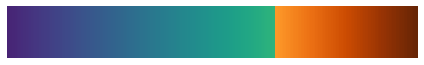

In [2]:
first = int((128 * 2) - np.round(255 * (1. - 0.65)))
second = (256 - first)
colors2 = plt.cm.viridis(np.linspace(0.1, .65, first))
colors3 = plt.cm.YlOrBr(np.linspace(0.5, 1., second))
colors1 = plt.cm.viridis(np.linspace(0., .98, first))
colors4 = plt.cm.YlOrBr(np.linspace(0.3, 0.90, second))
# combine them and build a new colormap
cols1 = np.vstack((colors2, colors3))
cols2 = np.vstack((colors1, colors4))

mymap1 = colors.LinearSegmentedColormap.from_list('my_colormap1', cols1)

num = 256
gradient = range(num)
for x in range(5):
    gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=mymap1, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

filename = 'colorbar.png'
plt.savefig(filename, dpi=400)
plt.show()

# load surfaces and cortex label

In [3]:
surf_lh = nib.freesurfer.read_geometry('DanielData/fsaverage5/surf/lh.inflated')
surf_rh = nib.freesurfer.read_geometry('DanielData/fsaverage5/surf/rh.inflated')

cort_lh = nib.freesurfer.read_label('DanielData/fsaverage5/label/lh.cortex.label')
cort_rh = nib.freesurfer.read_label('DanielData/fsaverage5/label/rh.cortex.label')
cort = np.concatenate((cort_lh, cort_rh + 10242))

# load subject timeseries

In [4]:
data = []
subjs = ['010005', '010017', '010018', '010021', '010024', '010032', '010042', '010056', '010060']
for s in subjs:
    data.append(np.load('DanielData/timeseries.sub-%s.npy' % s))
print(np.shape(data))

data1 = []
data2 = []
for d in range(len(data)):
    data1.append(np.hsplit(data[d], 2)[0])
    data2.append(np.hsplit(data[d], 2)[1])

newData = np.concatenate((data1,data2), axis=0)

(9, 18715, 2608)


# RUN GCCA

In [5]:
gcca = GCCA()
gcca.fit(newData)
projs = gcca.transform(newData)
print(np.shape(projs))

(18, 18715, 5)


# set visualization parameters

In [6]:
n_comps = np.shape(projs)[2]
if n_comps > 5:  # set max number of components to show at 5
    n_comps = 5

n_subs = np.shape(projs)[0]

n_views = 4  # number of brains to show per component
fig_width = 10

#  Plot pairwise components for group averages

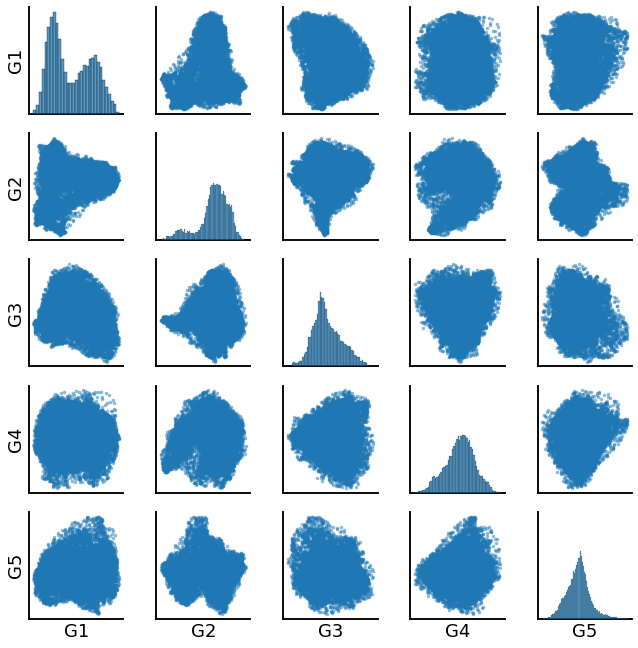

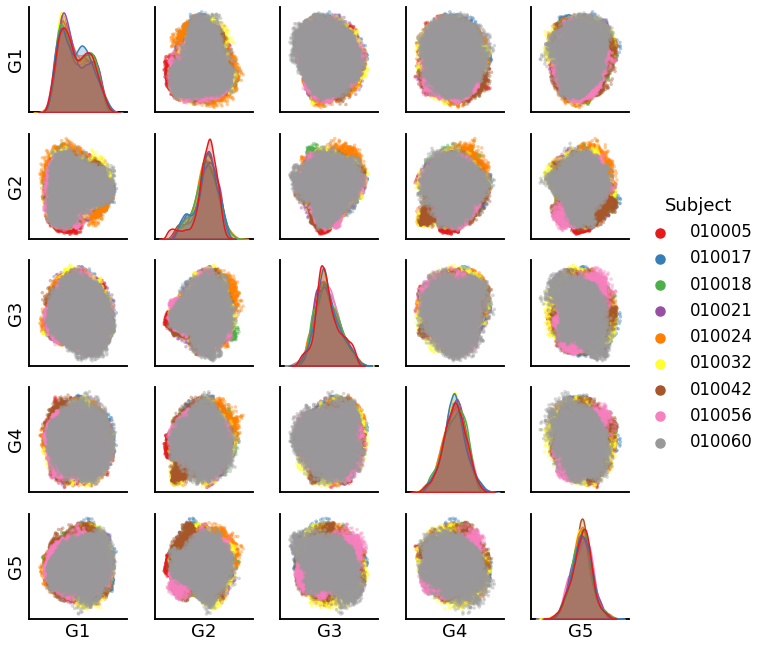

In [7]:
labels = []
for i in subjs:
   for j in range(projs[0].shape[0]):
       labels.append(i)

col_g = ['G1', 'G2', 'G3', 'G4', 'G5']

pairplot(np.mean(np.asarray(projs[9:,:,:n_comps]), axis=0), col_names =list(col_g),height=2, alpha=0.5)
plt.show()
pairplot(np.vstack(projs[9:,:,:n_comps]),col_names = col_g, labels=labels, height=2,
         legend_name='Subject', alpha=0.4)
filename = 'SubMatrix1.png'
plt.savefig(filename, dpi=400)
plt.show()

# Visualize group-level average components

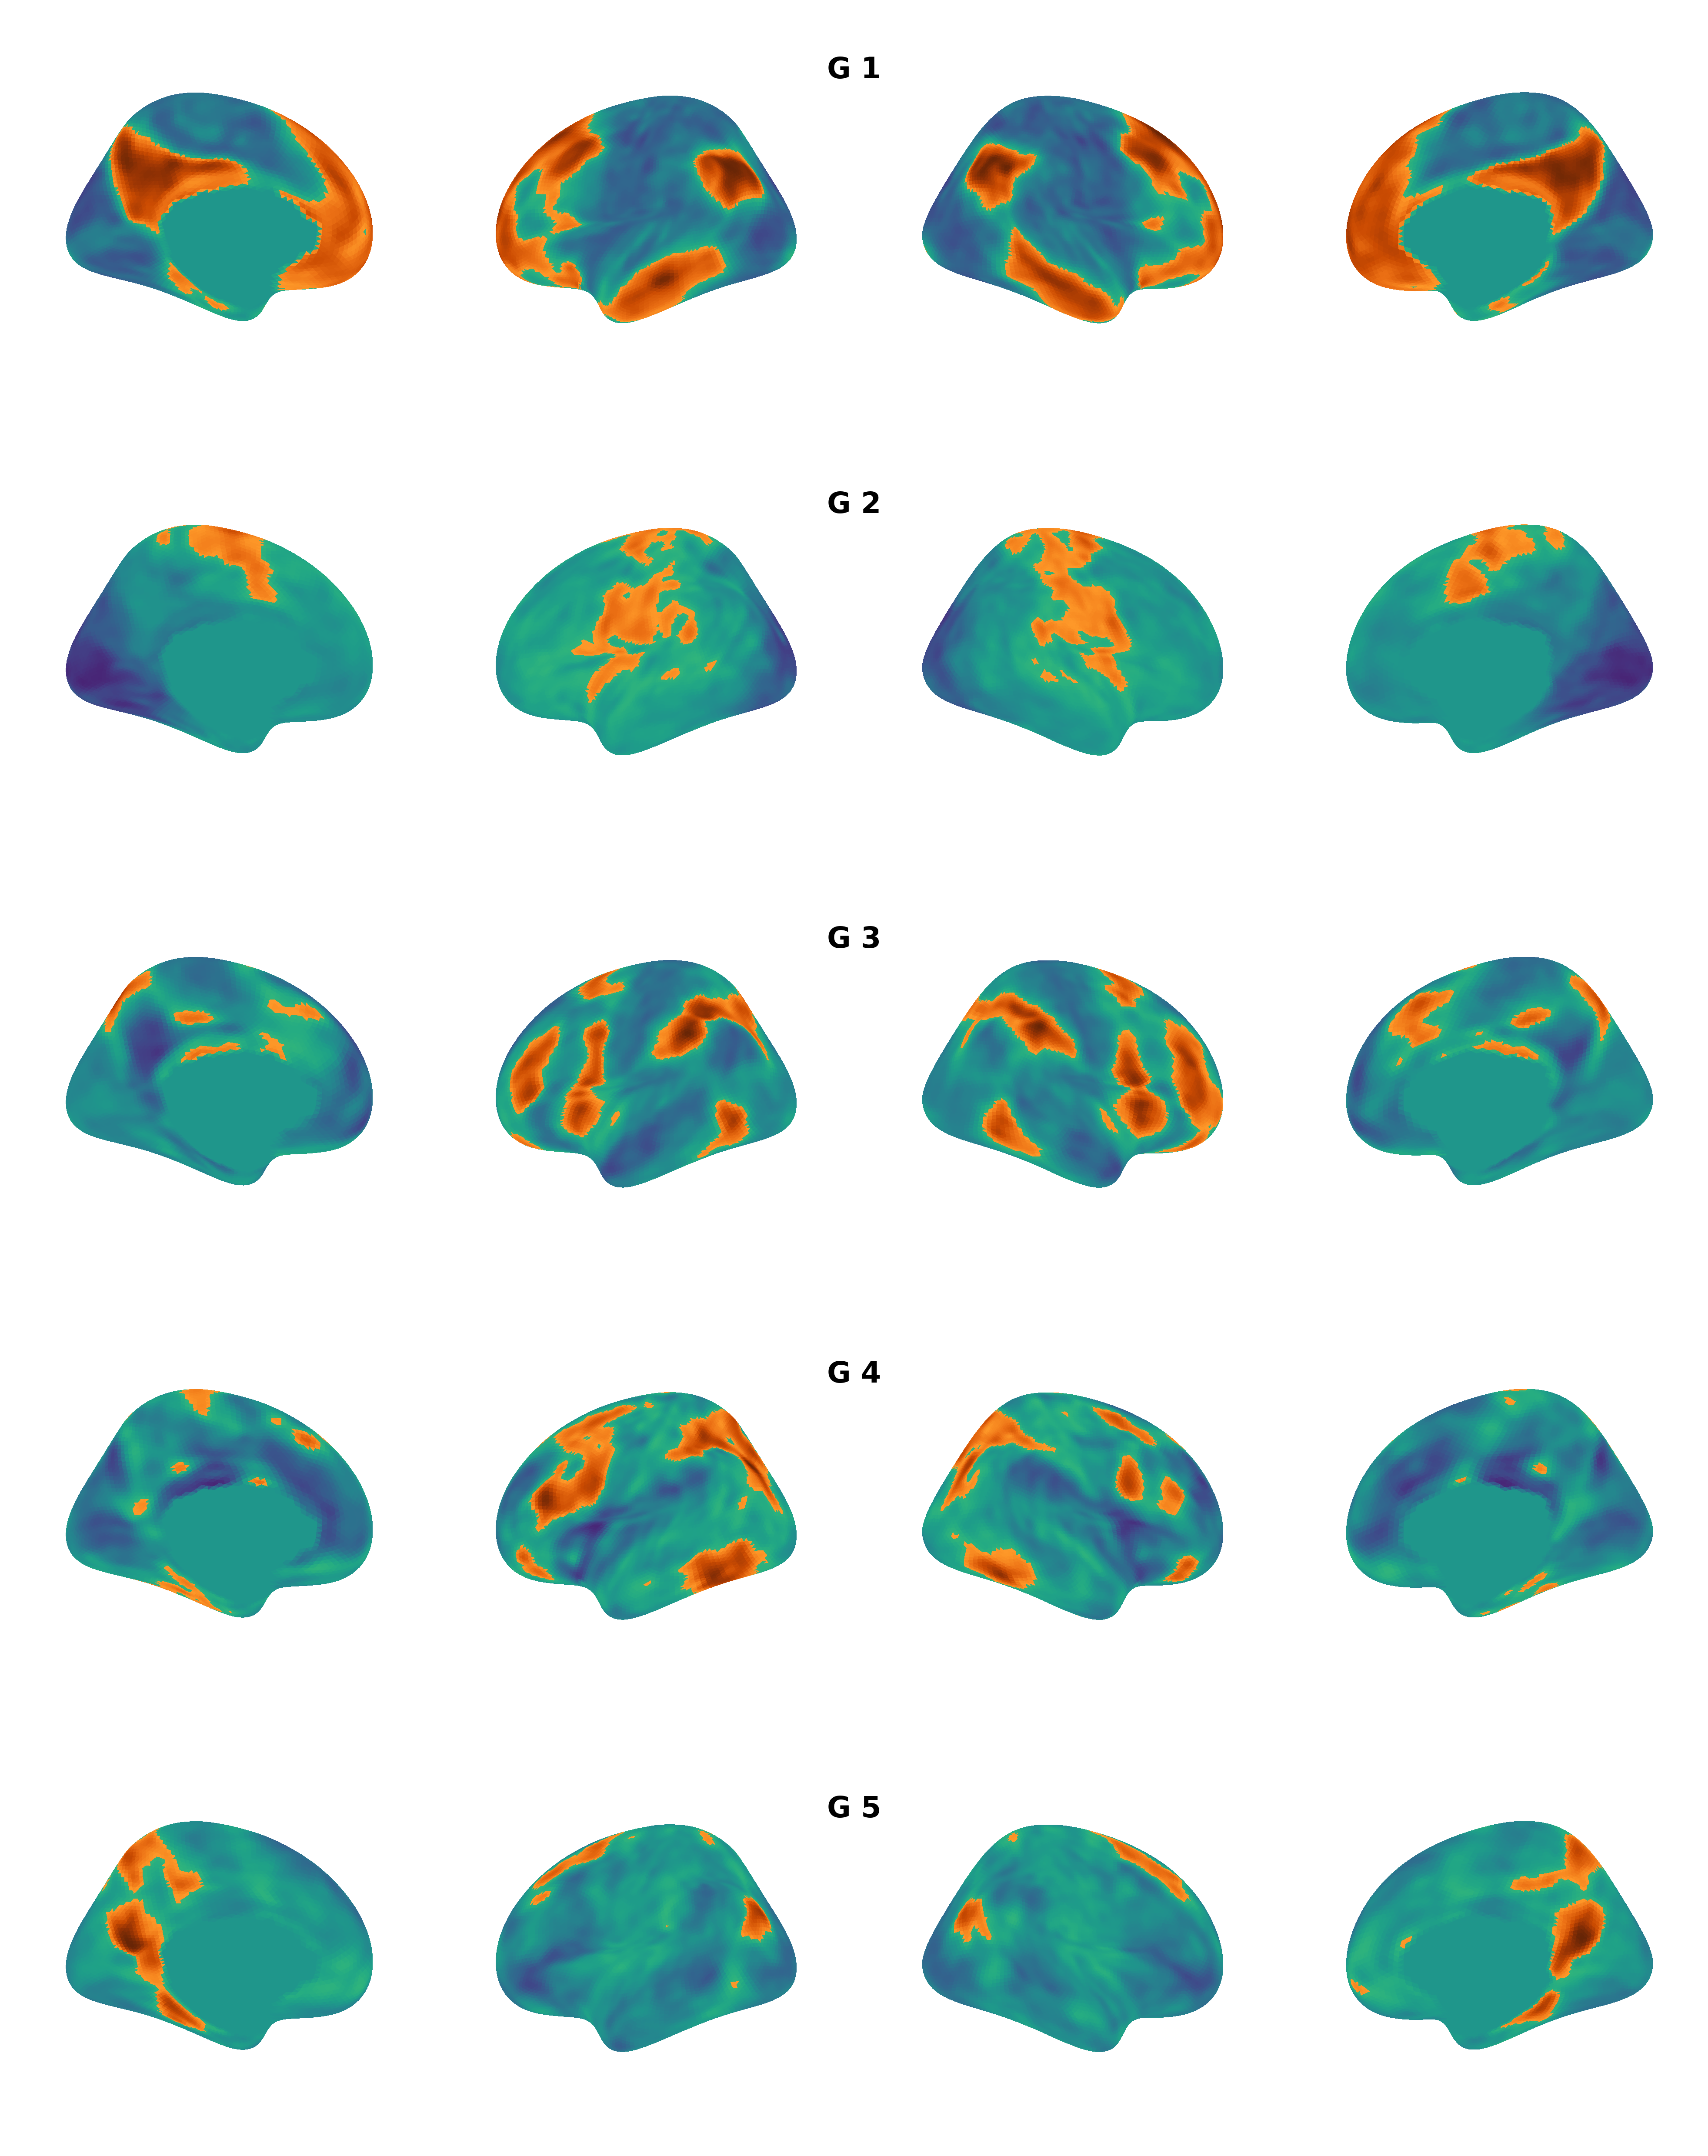

In [8]:
fig = plt.figure(figsize=(fig_width, fig_width * n_comps * 0.25), dpi=400)
for component in range(n_comps):
    ax1 = fig.add_subplot(n_comps, n_views, component * n_views + 1, projection='3d')
    ax2 = fig.add_subplot(n_comps, n_views, component * n_views + 2, projection='3d')
    ax3 = fig.add_subplot(n_comps, n_views, component * n_views + 3, projection='3d')
    ax4 = fig.add_subplot(n_comps, n_views, component * n_views + 4, projection='3d')
    res = np.zeros(10242)
    res[cort_lh] = np.mean(np.asarray(projs)[:, :len(cort_lh), component], axis=0)
    plax1 = plot_surf_stat_map(surf_lh, res, hemi='left', view='medial', axes=ax1, colorbar=False, cmap=mymap1)
    plax2 = plot_surf_stat_map(surf_lh, res, hemi='left', view='lateral', axes=ax2, colorbar=False, cmap=mymap1)
    res = np.zeros(10242)
    res[cort_rh] = np.mean(np.asarray(projs)[:, len(cort_lh):, component], axis=0)

    plax3 = plot_surf_stat_map(surf_rh, res, hemi='right', view='lateral', axes=ax3, colorbar=False, cmap=mymap1)
    plax4 = plot_surf_stat_map(surf_rh, res, hemi='right', view='medial', axes=ax4, colorbar=False, cmap=mymap1)
    plt.figtext(0.5, 0.96 - (1. / n_comps) * component, 'G %i' % int(int(component) + 1),
                horizontalalignment='center', fontsize='large',fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(hspace=0.1,wspace=0.05)

In [9]:
filename = 'TestRetestDanielDataGroup.png'
plt.savefig(filename, dpi=400)
plt.show()

<Figure size 432x288 with 0 Axes>

# JSD functions

In [10]:

def compute_probs(data, n):
    h, e = np.histogram(data, n)
    p = h / data.shape[0]
    return e, p


def support_intersection(p, q):
    sup_int = (
        list(
            filter(
                lambda x: (x[0] != 0) & (x[1] != 0), zip(p, q)
            )
        )
    )
    return sup_int


def get_probs(list_of_tuples):
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q


def kl_divergence(p, q):
    return np.sum(p * np.log(p / q))


def js_divergence(p, q):
    m = (1. / 2.) * (p + q)
    return (1. / 2.) * kl_divergence(p, m) + (1. / 2.) * kl_divergence(q, m)


def compute_kl_divergence(train_sample, test_sample, n_bins):
    """
    Computes the KL Divergence using the support
    intersection between two different samples
    """
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)

    list_of_tuples = support_intersection(p, q)
    p, q = get_probs(list_of_tuples)

    return kl_divergence(p, q)


def compute_js_divergence(train_sample, test_sample, n_bins):
    """
    Computes the JS Divergence using the support
    intersection between two different samples
    """
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)

    list_of_tuples = support_intersection(p, q)
    p, q = get_probs(list_of_tuples)

    return js_divergence(p, q)


def js(p, q):
    p = np.asarray(p)
    q = np.asarray(q)

    # normalize
    p /= p.sum()
    q /= q.sum()
    m = (p + q) / 2
    return (entropy(p, m) + entropy(q, m)) / 2

# Split Projs Data

In [11]:
projsrun1 = (np.split(projs, 2)[0])
projsrun2 = (np.split(projs, 2)[1])

# Organize the data

In [12]:
subPcarun1 = []
subPcarun2 = []
for i in range(0, 1):
    temp1 = []
    temp2 = []
    for j in range(np.shape(projsrun1)[0]):
        temp1.append((projsrun1[j][:, i]))
        temp2.append((projsrun2[j][:, i]))
    subPcarun1.append(np.array(temp1))
    subPcarun2.append(np.array(temp2))
print(subPcarun1[0][0])
n_bins = 512

[ 0.01839846  0.03816655  0.01373356 ...  0.00738877  0.00430301
 -0.01317998]


# ID Analysis

In [13]:
PCA_JSD = []
tempJSD = []
DF_PCA_JSD = []

for i in range(subPcarun1[0].shape[0]):
    tempJSD = []
    for j in range(subPcarun2[0].shape[0]):
        tempJSD.append((1 - (compute_js_divergence(subPcarun2[0][j], subPcarun1[0][i], n_bins=n_bins))))
    PCA_JSD.append(np.array(tempJSD))
DF_PCA_JSD = pd.DataFrame(PCA_JSD)

# JSD PLOT

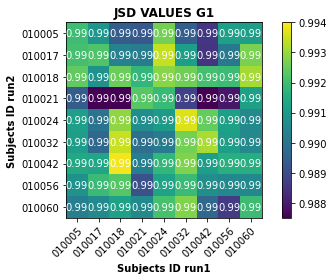

In [14]:
fig, ax = plt.subplots()
im = ax.imshow(DF_PCA_JSD, vmax=0.994, vmin=0.9875)

# We want to show all ticks...
ax.set_xticks(np.arange(len(subjs)))
ax.set_yticks(np.arange(len(subjs)))
# ... and label them with the respective list entries
ax.set_xticklabels(subjs)
ax.set_yticklabels(subjs)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(subjs)):
    for j in range(len(subjs)):
        text = ax.text(j, i, "{:.2f}".format(DF_PCA_JSD[i][j]),
                       ha="center", va="center", color="w")
fig.colorbar(im, ax=ax)
ax.set_title("JSD VALUES G1", fontweight='bold')
plt.xlabel("Subjects ID run1", fontweight='bold')
plt.ylabel("Subjects ID run2", fontweight='bold')
fig.tight_layout()

filename = 'PCA1_JSD_V .png'
plt.savefig(filename, dpi=400)
plt.show()
